In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import random
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense



In [2]:
SEED = 42

def set_all_seeds(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [3]:
# import real data

real_wti = pd.read_csv('data/wti_prices.csv', parse_dates=['Date'])
real_wti['log_return'] = np.log(real_wti['WTI_price'] / real_wti['WTI_price'].shift(1))
# drop the first row
real_wti = real_wti.dropna().reset_index(drop=True)


# training, validation, and test sets by 70/15/15
train_size = int(len(real_wti) * 0.7)
val_size = int(len(real_wti) * 0.15)

train_df = real_wti.iloc[:train_size].copy()
val_df   = real_wti.iloc[train_size:train_size + val_size].copy()
test_df  = real_wti.iloc[train_size + val_size:].copy()


In [4]:
# import synthetic data

syn_wti = pd.read_csv('data/synthetic_wti_15yr.csv')
syn_wti.head()

,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,sample_10
0,0.546375,0.548041,0.544946,0.528788,0.548058,0.551262,0.547550,0.529859,0.538588,0.552513
1,0.513848,0.516641,0.500619,0.441270,0.508923,0.535297,0.524638,0.469276,0.485031,0.518997
2,0.524256,0.520927,0.503322,0.447546,0.505836,0.549930,0.559994,0.511281,0.496820,0.508989
3,0.480836,0.494966,0.511987,0.563206,0.476474,0.466730,0.549521,0.595115,0.522891,0.462312
4,0.393336,0.432560,0.512589,0.658096,0.452526,0.337143,0.418552,0.630329,0.556758,0.414861


In [5]:
# Build LSTM model

def scale_data(train, val, test):
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train[['log_return']])
    val_scaled = scaler.transform(val[['log_return']])
    test_scaled = scaler.transform(test[['log_return']])
    return train_scaled, val_scaled, test_scaled, scaler

def create_sequences(data, lookback, horizon):

    X, y = [], []
    for t in range(lookback, len(data) - horizon + 1):
        X.append(data[t - lookback:t, :])
        y.append(data[t + horizon - 1, 0])
    return np.array(X), np.array(y)

# Increase sample size by 25% of the training set size
Current training sample set is 336 observations

In [6]:
# get first real date to fill in the dates later
first_real_date = train_df["Date"].min()
syn_num = 0.25*len(train_df) 
syn_dates = pd.date_range(
    end=first_real_date - pd.DateOffset(months=1),
    periods=syn_num,
    freq="MS"   
)

# take the last 84 observations of syn_wti and appens to start of train_df
syn_wti_last_84 = syn_wti['sample_1'].values[-84:]
train_sample1 = pd.concat([pd.DataFrame({'log_return': syn_wti_last_84}), train_df], ignore_index=True)
train_sample1.loc[:syn_num-1, "Date"] = syn_dates

print(len(train_sample1))

# scale the data
train_scaled1, val_scaled1, test_scaled1, scaler1 = scale_data(train_sample1, val_df, test_df)


420


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [9]:
def build_model(base_lookback, base_units, base_dropout, lr=0.001):
    model = Sequential([
        LSTM(base_units, input_shape=(base_lookback, 1), return_sequences=True),
        Dropout(base_dropout),
        LSTM(base_units // 2),
        Dropout(base_dropout),
        Dense(1)
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="mse"
    )
    
    return model

In [15]:
def eval_config(train_scaled, val_scaled, config, horizon=1):
    set_all_seeds(SEED)
    tf.keras.backend.clear_session()

    lb = config["lookback"]
    model = build_model(lb, config["units"], config["dropout"])

    X_train, y_train = create_sequences(train_scaled, lb, horizon=horizon)
    X_val, y_val     = create_sequences(val_scaled,   lb, horizon=horizon)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=config["epochs"],
        batch_size=config["batch_size"],
        verbose=0
    )

    # use best val loss during training
    best_val = float(np.min(history.history["val_loss"]))
    best_tr  = float(np.min(history.history["loss"]))
    return best_val, best_tr


def greedy_search(train_scaled, val_scaled, base_config, search_space):

    config = base_config.copy()

    best_val, best_tr = eval_config(train_scaled, val_scaled, config)

    history_rows = [{
        **config,
        "train_loss": best_tr,
        "val_loss": best_val,
        "changed": "init"
    }]

    for param, candidates in search_space.items():

        current_best_val = best_val
        current_best_cfg = config.copy()
        current_best_tr  = best_tr

        for cand in candidates:

            trial = config.copy()
            trial[param] = cand

            val, tr = eval_config(train_scaled, val_scaled, trial)

            if val < current_best_val:

                current_best_val = val
                current_best_cfg = trial
                current_best_tr  = tr

        if current_best_val < best_val:

            config = current_best_cfg
            best_val = current_best_val
            best_tr  = current_best_tr

            history_rows.append({
                **config,
                "train_loss": best_tr,
                "val_loss": best_val,
                "changed": param
            })

    return config, pd.DataFrame(history_rows)



In [16]:
# baseline model parameters based on Ly et al. (2021)
base_lookback = 10
base_dropout = 0.1
base_units = 50
base_epoch = 50
base_batch_size = 32

base_config = { 
    "lookback": base_lookback,
    "dropout": base_dropout,
    "units": base_units,
    "epochs": base_epoch,
    "batch_size": base_batch_size
}

search_space = {

    "lookback": [1, 2, 4, 6, 8, 10],

    "dropout": [0.0, 0.001, 0.01, 0.03, 0.1],

    "units": [10, 50, 90, 130, 170],

    "epochs": [20, 40, 60, 80, 100],

    "batch_size": [16, 32, 64]

}

In [17]:
best_config1, greedy_results_df1 = greedy_search(
    train_scaled1,
    val_scaled1,
    base_config,
    search_space
)

print("Best configuration:")
print(best_config1)

print("\nSearch history:")
print(greedy_results_df1)

2026-02-18 19:44:56.600161: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Best configuration:
{'lookback': 1, 'dropout': 0.01, 'units': 10, 'epochs': 50, 'batch_size': 32}

Search history:
   lookback  dropout  units  epochs  batch_size  train_loss  val_loss  \
0        10     0.10     50      50          32    0.167857  0.174447   
1         1     0.10     50      50          32    0.180615  0.154416   
2         1     0.01     50      50          32    0.181659  0.153795   
3         1     0.01     10      50          32    0.167053  0.153080   

    changed  
0      init  
1  lookback  
2   dropout  
3     units  


In [18]:
# train final model with best config on train + val, and evaluate on test
final_lookback1 = 1
final_units1 = 10
final_dropout1 = 0.01
final_epochs1 = 50
final_batch_size1 = 32

set_all_seeds(SEED)

model_final = build_model(
    final_lookback1,
    final_units1,
    final_dropout1
)

X_train, y_train = create_sequences(train_scaled1, final_lookback1, horizon=1)
X_val, y_val     = create_sequences(val_scaled1, final_lookback1, horizon=1)

history = model_final.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=final_epochs1,
    batch_size=final_batch_size1,
    verbose=0
)

X_test, y_test = create_sequences(test_scaled1, final_lookback1, horizon=1)
y_pred_scaled = model_final.predict(X_test)

# inverse transform
y_pred = scaler1.inverse_transform(y_pred_scaled)
y_test_raw = scaler1.inverse_transform(y_test.reshape(-1,1))




3/3 [==============================] - 0s 1ms/step


In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse  = mean_squared_error(y_test_raw, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test_raw, y_pred)
r2   = r2_score(y_test_raw, y_pred)

print(f"RMSE: {rmse:.6f}")
print(f"MAE:  {mae:.6f}")
print(f"MSE:  {mse:.6f}")
print(f"R2:   {r2:.6f}")

results_df = pd.DataFrame({
    "Model": ["Add 25%"],
    "RMSE": [rmse],
    "MAE": [mae],
    "MSE": [mse],
    "R2": [r2]
})

print(results_df)


RMSE: 0.135970
MAE:  0.083791
MSE:  0.018488
R2:   0.025607
     Model     RMSE       MAE       MSE        R2
0  Add 25%  0.13597  0.083791  0.018488  0.025607


# Add 50% synthetic data

In [25]:
syn_num = 0.5*len(train_df) 
syn_dates = pd.date_range(
    end=first_real_date - pd.DateOffset(months=1),
    periods=syn_num,
    freq="MS"   
)

# take the last 168 observations of syn_wti and appens to start of train_df
syn_wti_last_168 = syn_wti['sample_1'].values[-168:]
train_sample2 = pd.concat([pd.DataFrame({'log_return': syn_wti_last_168}), train_df], ignore_index=True)
train_sample2.loc[:syn_num-1, "Date"] = syn_dates

print(len(train_sample2))

# scale the data
train_scaled2, val_scaled2, test_scaled2, scaler2 = scale_data(train_sample2, val_df, test_df)


504


In [26]:
best_config2, greedy_results_df2 = greedy_search(
    train_scaled2,
    val_scaled2,
    base_config,
    search_space
)

print("Best configuration:")
print(best_config2)

print("\nSearch history:")
print(greedy_results_df2)

Best configuration:
{'lookback': 1, 'dropout': 0.03, 'units': 10, 'epochs': 100, 'batch_size': 16}

Search history:
   lookback  dropout  units  epochs  batch_size  train_loss  val_loss  \
0        10     0.10     50      50          32    0.107394  0.130832   
1         1     0.10     50      50          32    0.130039  0.119168   
2         1     0.03     50      50          32    0.128240  0.118967   
3         1     0.03     10      50          32    0.123635  0.117267   
4         1     0.03     10     100          32    0.117573  0.116700   
5         1     0.03     10     100          16    0.116912  0.116265   

      changed  
0        init  
1    lookback  
2     dropout  
3       units  
4      epochs  
5  batch_size  


In [27]:
final_lookback2 = 1
final_units2 = 10
final_dropout2 = 0.03
final_epochs2 = 100
final_batch_size2 = 16

set_all_seeds(SEED)

model_final2 = build_model(
    final_lookback2,
    final_units2,
    final_dropout2
)

X_train, y_train = create_sequences(train_scaled2, final_lookback2, horizon=1)
X_val, y_val     = create_sequences(val_scaled2, final_lookback2, horizon=1)

history = model_final2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=final_epochs2,
    batch_size=final_batch_size2,
    verbose=0
)

X_test, y_test = create_sequences(test_scaled2, final_lookback2, horizon=1)
y_pred_scaled2 = model_final2.predict(X_test)

# inverse transform
y_pred2 = scaler2.inverse_transform(y_pred_scaled2)
y_test_raw2 = scaler2.inverse_transform(y_test.reshape(-1,1))




3/3 [==============================] - 1s 1ms/step


In [28]:
mse2  = mean_squared_error(y_test_raw2, y_pred2)
rmse2 = np.sqrt(mse2)
mae2  = mean_absolute_error(y_test_raw2, y_pred2)
r2_2   = r2_score(y_test_raw2, y_pred2)

print(f"RMSE: {rmse2:.6f}")
print(f"MAE:  {mae2:.6f}")
print(f"MSE:  {mse2:.6f}")
print(f"R2:   {r2_2:.6f}")

results_df = pd.DataFrame({
    "Model": ["Add 25%", "Add 50%"],
    "RMSE":  [rmse, rmse2],
    "MAE":   [mae,  mae2],
    "MSE":   [mse,  mse2],
    "R2":    [r2,   r2_2]
})

print(results_df)


RMSE: 0.136162
MAE:  0.083982
MSE:  0.018540
R2:   0.022852
     Model      RMSE       MAE       MSE        R2
0  Add 25%  0.135970  0.083791  0.018488  0.025607
1  Add 50%  0.136162  0.083982  0.018540  0.022852


# Add 100% of synthetic data

In [36]:
syn_num = len(train_df) 
syn_dates = pd.date_range(
    end=first_real_date - pd.DateOffset(months=1),
    periods=syn_num,
    freq="MS"   
)

# take 156 from sample 2 column
part2 = syn_wti['sample_2'].values[:156]

# take all 180 from sample_1
part1 = syn_wti['sample_1'].values 

# combine: sample_2 first, then sample_1 then with train_df
syn_wti_mix = np.concatenate([part2, part1], axis=0)
train_sample3 = pd.concat(
    [pd.DataFrame({'log_return': syn_wti_mix}), train_df],
    ignore_index=True
)

syn_num = len(syn_wti_mix)
train_sample3.loc[:syn_num-1, "Date"] = syn_dates[:syn_num]

# scale the data
train_scaled3, val_scaled3, test_scaled3, scaler3 = scale_data(train_sample3, val_df, test_df)




In [37]:
best_config3, greedy_results_df3 = greedy_search(
    train_scaled3,
    val_scaled3,
    base_config,
    search_space
)

print("Best configuration:")
print(best_config3)

print("\nSearch history:")
print(greedy_results_df3)

Best configuration:
{'lookback': 2, 'dropout': 0.1, 'units': 170, 'epochs': 50, 'batch_size': 32}

Search history:
   lookback  dropout  units  epochs  batch_size  train_loss  val_loss  \
0        10      0.1     50      50          32    0.076151  0.116271   
1         2      0.1     50      50          32    0.075686  0.103101   
2         2      0.1    170      50          32    0.073123  0.100011   

    changed  
0      init  
1  lookback  
2     units  


In [38]:
final_lookback3 = 2
final_units3 = 170
final_dropout3 = 0.1
final_epochs3 = 50
final_batch_size3 = 32

set_all_seeds(SEED)

model_final3 = build_model(
    final_lookback3,
    final_units3,
    final_dropout3
)

X_train, y_train = create_sequences(train_scaled3, final_lookback3, horizon=1)
X_val, y_val     = create_sequences(val_scaled3, final_lookback3, horizon=1)

history = model_final3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=final_epochs3,
    batch_size=final_batch_size3,
    verbose=0
)

X_test, y_test = create_sequences(test_scaled3, final_lookback3, horizon=1)
y_pred_scaled3 = model_final3.predict(X_test)

# inverse transform
y_pred3 = scaler3.inverse_transform(y_pred_scaled3)
y_test_raw3 = scaler3.inverse_transform(y_test.reshape(-1,1))




3/3 [==============================] - 0s 2ms/step


In [47]:
mse3  = mean_squared_error(y_test_raw3, y_pred3)
rmse3 = np.sqrt(mse3)
mae3  = mean_absolute_error(y_test_raw3, y_pred3)
r2_3   = r2_score(y_test_raw3, y_pred3)

print(f"RMSE: {rmse3:.6f}")
print(f"MAE:  {mae3:.6f}")
print(f"MSE:  {mse3:.6f}")
print(f"R2:   {r2_3:.6f}")

results_df = pd.DataFrame({
    "Model": ["Add 25%", "Add 50%", "Add 100%"], 
    "RMSE":  [rmse, rmse2, rmse3],
    "MAE":   [mae,  mae2, mae3],
    "MSE":   [mse,  mse2, mse3],
    "R2":    [r2,   r2_2, r2_3]
})

print(results_df)




RMSE: 0.118309
MAE:  0.077240
MSE:  0.013997
R2:   0.057486
      Model      RMSE       MAE       MSE        R2
0   Add 25%  0.135970  0.083791  0.018488  0.025607
1   Add 50%  0.136162  0.083982  0.018540  0.022852
2  Add 100%  0.118309  0.077240  0.013997  0.057486


In [48]:
# export the results to csv
results_df.to_csv("lstm_timegan_results.csv", index=False)

In [42]:
max_lookback = 2  

test_dates = test_df["Date"].iloc[max_lookback:].reset_index(drop=True)

df_export = pd.DataFrame({
    "date": test_dates,
    "actual": y_test_raw3.flatten(),   
    "pred_25": y_pred[max_lookback-1:].flatten(),
    "pred_50": y_pred2[max_lookback-1:].flatten(),
    "pred_100": y_pred3.flatten()
})

df_export.to_csv("lstm_timegan_predictions.csv", index=False)


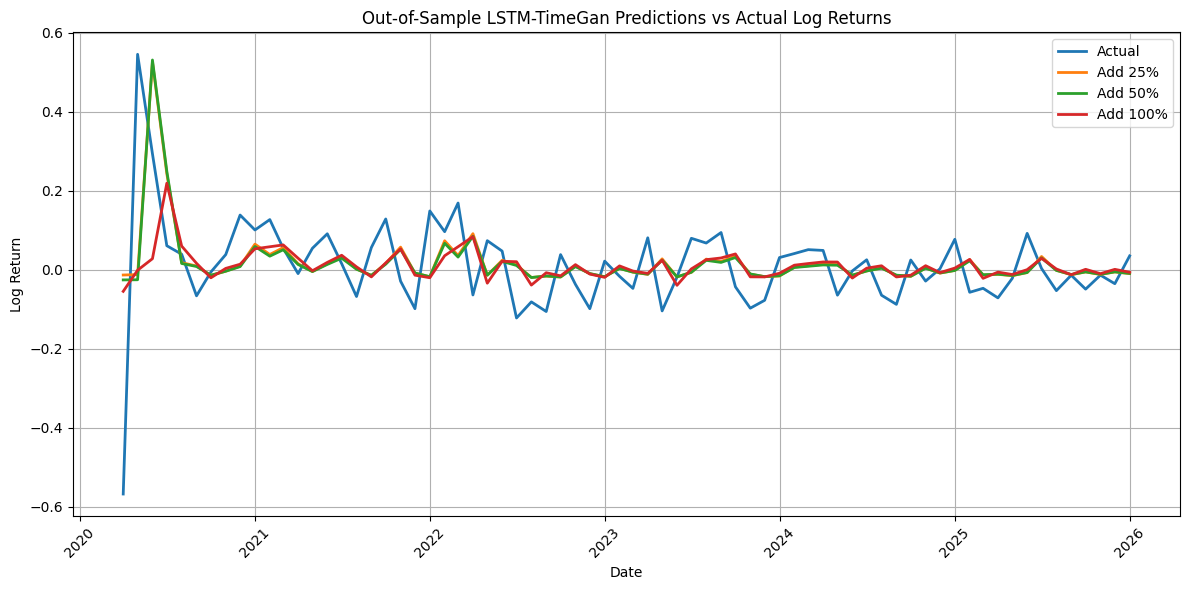

In [45]:
df = pd.read_csv("lstm_timegan_predictions.csv")

# convert to datetime
df["date"] = pd.to_datetime(df["date"])
plt.figure(figsize=(12,6))

plt.plot(df["date"], df["actual"], label="Actual", linewidth=2)
plt.plot(df["date"], df["pred_25"], label="Add 25%", linewidth=2)
plt.plot(df["date"], df["pred_50"], label="Add 50%", linewidth=2)
plt.plot(df["date"], df["pred_100"], label="Add 100%", linewidth=2)

plt.title("Out-of-Sample LSTM-TimeGan Predictions vs Actual Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")

plt.legend()
plt.grid(True)

plt.xticks(rotation=45)  
plt.tight_layout()

plt.show()
